In [1]:
import re
import numpy as np
import time
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import spacy
from datetime import datetime
from spacy.lang.pt.examples import sentences
pd.options.display.max_colwidth = 100

# Data Analysis

In [2]:
def split_questions(options):
    """This function receives a list of options and returns them as a list"""
    if isinstance(options, list):
        options = options.split('\n')[1:]
        # If the answers are only 'True' or 'False', there is no need of excluding elements
        if len(options) == 2:
            return options
        # If there are five answer options, the letters need to be excluded
        else:
            return options[1::2]
    else:
        return options
    
def find_articles(text):
    """This function searches for 'artigo', 'artigos', 'art' and 'art' in the questions."""
    # If the text is a list of options, we need to convert them to str
    if isinstance(text, list):
        text = ' --- '.join(text)
    has_articles = re.findall('(artigos?|art\.?) ', text.lower())
    if has_articles:
        #list_articles = re.findall('(artigos? \d+|art\.? \d+,? ? [\w\W]?)', text.lower().replace('.', '').replace('º',''))
        text = text.lower().replace('.', '').replace('º', '')
        # Pattern para 'artigo 19 da lei' e variações
        pattern = r'(?:artigos?|art.?)\s?\d*[\w-]+\s?(?:do|da|dos|das)?\s?\w*\s?\w*\s?\w*'
        list_articles = re.findall(pattern, text)
        # Pattern para 'artigos 18, 19 e 20' e variações; ou 'artigo 18, V'
        pattern = r'(?:artigos?|art.?)\s?\d*[\w-]+(?:,\s?[\d]*[\w]*)*(?:\s?e?\s?\d+)?'
        list_articles.extend(re.findall(pattern, text))
        if list_articles:
            return list_articles
    return np.nan

def find_paragraphs(text):
    if isinstance(text, list):
        text = ' --- '.join(text)
    text = text.lower()
    has_paragraphs = re.findall(r'(?:parágrafos?|§) \d+|(?:parágrafos?|§) \w+', text)
    if has_paragraphs:
        return has_paragraphs
    return np.nan

def find_chapters(text):
    if isinstance(text, list):
        text = ' --- '.join(text)
    text = text.lower()
    has_chapters = re.findall(r'(?:cap.?í?t?u?l?o?s? [ivx\d]+)|(?:cap.?í?t?u?l?o?s? [\w\s?]*)', text)
    if has_chapters:
        return has_chapters
    return np.nan

def find_titles(text):
    if isinstance(text, list):
        text = ' --- '.join(text)
    text = text.lower()
    has_titles = re.findall(r'títulos? [ivx]+', text)
    if has_titles:
        return has_titles
    return np.nan

def find_incisos(text):
    # Not a perfect function; there are occasions where roman numerals are used that are not treated here.
    # So far, I just removed the situations where the functions find_titles e find_chapters already cover
    if isinstance(text, list):
        text = ' --- '.join(text)
    text = text.lower()
    has_incisos = re.findall(r'incisos? [ivx\d]*', text)
    text = re.sub(r'(^|títulos? |capítulos? |afirmativas? |ite[nm]s? )[ixv]+\s?[,e]?\s?[ixv]*\s?e?\s?[ixv]*', '', text)
    #text = re.sub(r'[ivx]+\', '', text)
    has_incisos.extend(re.findall(r'\s[ivx]+[^\.][\s,]', text))
    
    if has_incisos:
        return has_incisos
    return np.nan

def try_int(number):
    """This function enables a map function to make evaluations only on numbers and ignore string elements"""
    try:
        return int(number)
    except:
        return 0
    
def find_n_articles(list_of_articles):
    final_list = []
    for subset in list_of_articles:
        pattern = r'(?:artigos?|art.?)\s+\d+\s+[aà]\s+\d+'
        elements = re.findall(pattern, subset)
        if elements:
            for element in elements:
                element = element.split()
                init = element[1]
                end = element[3]
            final_list.extend(list(range(int(init), int(end)+1)))
        elements = re.findall(r'(?:artigos?|art.?)\s\d+\se\s\d+', subset)
        if elements:
            for element in elements:
                element = element.split()
                init = element[1]
                end = element[3]
            final_list.extend([int(init), int(end)])            
        else:
            match = re.search('\d+-?\w*', subset)
            if match:
                final_list.append(match.group())
    return set([str(x) for x in final_list])

In [4]:
# Reading the data and dropping unnecessary columns
df_questions = pd.read_csv('data/202367 - 12-52.csv', sep=';')
df_questions = df_questions.reset_index()
df_questions = df_questions.drop(['index', 'Unnamed: 0'], axis=1)
# Reading the data from different columns, finding its articles, combining them and dropping the original columns (pre-merge)
df_questions['options'] = df_questions['options'].map(split_questions)
df_questions['cited_articles'] = df_questions['enunciado'].map(find_articles)
df_questions['cited_articles_options'] = df_questions['options'].map(find_articles)
df_questions['articles_mentioned'] = df_questions['cited_articles_options'].combine_first(df_questions['cited_articles'])
mask_articles_not_na = df_questions['articles_mentioned'].notna()
df_questions['n_articles'] = df_questions[mask_articles_not_na].articles_mentioned.map(find_n_articles)
df_questions['n_articles'] = df_questions[mask_articles_not_na].n_articles.map(lambda x: {number for number in x if try_int(number) <= 267})
df_questions['paragraphs_mentioned'] = df_questions.enunciado.map(find_paragraphs)
df_questions['paragraphs_mentioned'] = df_questions['paragraphs_mentioned'].combine_first(df_questions.options.map(find_paragraphs))
df_questions['chapters_mentioned'] = df_questions.enunciado.map(find_chapters)
df_questions['chapters_mentioned'] = df_questions['chapters_mentioned'].combine_first(df_questions.options.map(find_chapters))
df_questions['titles_mentioned'] = df_questions.enunciado.map(find_titles)
df_questions['titles_mentioned'] = df_questions['titles_mentioned'].combine_first(df_questions.options.map(find_titles))
df_questions['incisos_mentioned'] = df_questions.enunciado.map(find_incisos)
df_questions = df_questions.drop_duplicates(['enunciado', 'ano', 'banca', 'orgao', 'prova'])

# Trying to define the job with splits

In [54]:
df_questions['split_data_exam'] = df_questions.prova.map(lambda x: x.lower().split(' - '))
df_exploded_info_exam = df_questions.split_data_exam.explode().reset_index()

In [55]:
def define_job(exam_info):
    job_info = exam_info.split(' - ')
    if len(job_info) >= 4:
        if len(job_info[3]) == 2:
            job_info = job_info[4:]
        else:
            job_info = job_info[3:]
    
    return [job.strip().lower().replace(' substituto', '').replace('vespertina', '') for job in job_info]
    

In [56]:
df_questions['job'] = df_questions.prova.map(define_job)

In [57]:
df_questions.job.value_counts()[40:60]

[assistente do sistema socioeducativo – assistente administrativo]                                  17
[professor de geografia]                                                                            17
[agente de proteção]                                                                                17
[promotor de justiça, prova 2]                                                                      17
[assessor jurídico]                                                                                 17
[professor de história]                                                                             17
[comissário da infância e da juventude]                                                             17
[agente comunitário de saúde]                                                                       17
[oficial judiciário]                                                                                16
[enfermeiro]                                                             

In [58]:
df_questions.iloc[2]

enunciado                 Juliana, ao receber sua nota do 2º trimestre em Biologia, não ficou contente, pois acha que a pr...
options                   ['É direito do aluno contestar critérios avaliativos, podendo recorrer às instâncias escolares s...
ano                                                                                                                      2023
banca                                                                                                                FUNDATEC
orgao                                                                                                    IF Farroupilha - RS 
prova                                                            FUNDATEC - 2023 - IF Farroupilha - RS - Assistente de Alunos
cited_articles                                                                                                            NaN
cited_articles_options                                                                                                

In [59]:
df_exploded_info_exam.groupby('split_data_exam').count().sort_values(by='index', ascending=False).reset_index().head(25)

,split_data_exam,index
0,2019,846
1,2018,557
2,vunesp,486
3,2022,465
4,cespe,463
5,sp,461
6,2015,422
7,assistente social,417
8,fcc,387
9,2014,336


# Analysing only the exams related with social workers

In [5]:
# Filtering only the questions for exams that are directed for social workers
df_social_workers = df_questions[df_questions['prova'].str.lower().str.contains('assistente social')]

We lost a ton of data; the analysis is fragile now, since from 4972 questions, only 819 mentions law articles, and only 114 are for the social worker job. Still, let's procede.

In [6]:
print(f'Original dataset size: {df_questions.shape}')
print(f'Original dataset with articles mentioned: {df_questions[df_questions.n_articles.notna()].shape}')
print(f'Social Worker dataset size: {df_social_workers.shape}')
print(f'Social Worker dataset with articles mentioned: {df_social_workers[df_social_workers.n_articles.notna()].shape}')

Original dataset size: (4972, 14)
Original dataset with articles mentioned: (819, 14)
Social Worker dataset size: (484, 14)
Social Worker dataset with articles mentioned: (114, 14)


Let's do a first analysis of the data, based on the articles mentioned

In [7]:
count_articles = pd.DataFrame(df_social_workers.n_articles.explode().value_counts()).reset_index().rename({'index':'count'}, axis=1)
count_articles

,count,n_articles
0,4,6
1,112,5
2,56,5
3,19,5
4,42,4
...,...,...
84,190,1
85,176,1
86,186,1
87,177,1


In [8]:
count_articles.n_articles.sum()

154

Temos 114 questões mencionando 154 artigos, havendo alguma margem de erro. O artigo mais citado é o artigo 4º do ECA, em 6 questões; seguido pelos artigos 112, 56 e 19 em 5 questões. Houve conferência visual da maior parte do dataframe final, havendo poucos erros como quando é citado um artigo de lei outra (como em df_social_workers[df_social_workers.index == 4432]). Não há menções da CF neste dataframe, apesar de haver no original, provavelmente ligado a provas do universo do direito, defensoria etc.

Apesar do reduzido dataframe, em comparação a cerca de 5000 questões iniciais, ainda é um indicativo da quantidade de questões que mencionam artigos específicos. Isso orienta o candidato a buscar em especial o estudo dos artigos: 4, 112, 56, 19, 136, 16, 25, 131, 42; aqueles que caem em até 2 provas talvez ainda seja interessante estudar. Artigos que só caíram em uma prova parecem menos significativos.

Ainda é possível uma análise vendo incisos, parágrafos e títulos específicos pedidos.

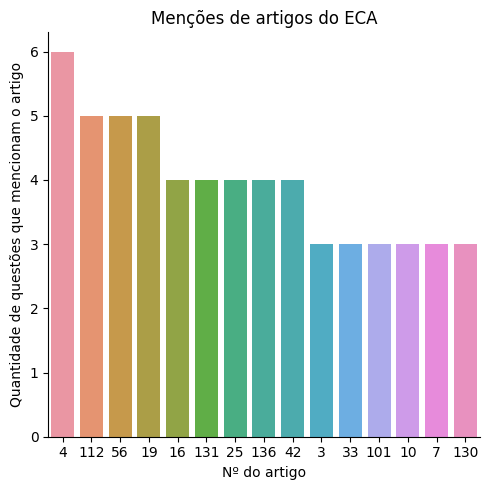

In [64]:
# Counting the articles mentioned in the original dataset and ordering by most asked articles
plt.subplots(figsize=(5, 5))
plt.title('Menções de artigos do ECA')
sns.barplot(data=count_articles.head(15), y='n_articles', x='count')
plt.xlabel('Nº do artigo')
plt.ylabel('Quantidade de questões que mencionam o artigo')
plt.tight_layout()

Does the data makes sense? Let's see in the law.

>Art. 4º É dever da família, da comunidade, da sociedade em geral e do poder público assegurar, com absoluta prioridade, a efetivação dos direitos referentes à vida, à saúde, à alimentação, à educação, ao esporte, ao lazer, à profissionalização, à cultura, à dignidade, ao respeito, à liberdade e à convivência familiar e comunitária.
>
> Parágrafo único. A garantia de prioridade compreende:
>
> a) primazia de receber proteção e socorro em quaisquer circunstâncias;
>
> b) precedência de atendimento nos serviços públicos ou de relevância pública;
>
> c) preferência na formulação e na execução das políticas sociais públicas;
>
> d) destinação privilegiada de recursos públicos nas áreas relacionadas com a proteção à infância e à juventude."""

Now, let's compare with the data of all the questions that mention article 4. For that, we need to find a way to search for a specific article.

In [9]:
mask_articles_not_na = df_social_workers['n_articles'].notna()
df_exploded_articles = df_social_workers[mask_articles_not_na]['n_articles'].explode().reset_index()

In [10]:
df_social_workers[mask_articles_not_na]['n_articles'].explode().reset_index()

,index,n_articles
0,14,11
1,90,3
2,128,141
3,129,132
4,130,130
...,...,...
153,4771,5
154,4777,101
155,4793,87
156,4913,10


In [14]:
df_final = pd.merge(left=df_social_workers, right=df_exploded_articles, left_index=True, right_on='index')

Now that we have a dataframe that duplicated the questions so we can search for specific articles in those questions, let's see what we got:

In [16]:
pd.options.display.max_colwidth = 500
df_final[df_final['n_articles_y'] == '4'][['enunciado', 'options']]

,enunciado,options
42,"A luz do Estatuto da Criança e do Adolescente (1990), o que significa dizer que crianças e adolescentes passam a ser sujeitos de direitos sob a ótica do Direito da Criança e do Adolescente?","['Significa dizer que somente fazem jus aos direitos expressamente regulados pelo Código Civil Brasileiro.', 'Expressa o fato de que crianças e adolescentes possuem não apenas os direitos comuns a todos os cidadãos, mas também os direitos relativos à condição peculiar de pessoas em desenvolvimento, como aqueles relacionados à prioridade absoluta, previstos no artigo 4º, parágrafo único do Estatuto da Criança e do adolescente (ECA).', 'Representa afirmar que crianças e adolescentes não possue..."
44,"O Art. 4º, da Lei, n 8.069, de 13 de Julho de 1990, dispõe que: “é dever da família, da comunidade, da sociedade em geral e do poder público assegurar, com absoluta prioridade, a efetivação dos direitos referentes à vida, à saúde, à alimentação, à educação, ao esporte, ao lazer, à profissionalização, à cultura, à dignidade, ao respeito, à liberdade e à convivência familiar e comunitária"". Das alternativas abaixo, indique a que “não faz parte""do Parágrafo único, que delimita garantia de prior...","['primazia de receber proteção e socorro em quaisquer circunstâncias;', 'precedência de atendimento nos serviços públicos ou de relevância pública;', 'preferência na formulação e na execução das políticas sociais públicas;', 'destinação privilegiada de recursos públicos nas áreas relacionadas com a proteção dos animais em risco de extinção.']"
56,"É dever da família, da comunidade, da sociedade em geral e do poder público assegurar, com absoluta prioridade, a efetivação dos direitos referentes à vida, à saúde, à alimentação, à educação, ao esporte, ao lazer, à profissionalização, à cultura, à dignidade, ao respeito, à liberdade e à convivência familiar e comunitária.\nMarque a alternativa que está de acordo com Art. 4º da Lei nº 8.069/1990:\n(Fonte: http://www.planalto.gov.br/ccivil_03/leis/l8069.htm)","['Proceder a exames visando ao diagnóstico e terapêutica de anormalidades no metabolismo do recém-nascido, bem como prestar orientação aos pais.', 'Identificar o recém-nascido mediante o registro de sua impressão plantar e digital e da impressão digital da mãe, sem prejuízo de outras formas normatizadas pela autoridade administrativa competente.', 'Fornecer declaração de nascimento onde constem necessariamente as intercorrências do parto e do desenvolvimento do neonato.', 'Destinação privile..."
122,"O Estatuto da Criança e do Adolescente em seu art. 4° , preconiza que é dever da família, da comunidade, da sociedade em geral e do poder público assegurar, com absoluta prioridade, a efetivação dos direitos de crianças e adolescentes. A garantia dessa prioridade compreende","['primazia de receber proteção e socorro para as situações que envolvem a saúde e educação, não abrangendo quaisquer outras circunstâncias.', 'precedência de atendimento nos serviços públicos e privados, sobretudo para a criança que se encontra na primeira infância.', 'preferência na formulação e na execução das políticas sociais públicas.', 'destinação privilegiada de recurso público aos Fundos da Criança e do Adolescente para a manutenção continuada de serviços das diferentes políticas set..."
123,"Relativo ao princípio da prioridade absoluta, previsto no artigo 4º do Estatuto da Criança e do Adolescente (1990), julgue as alternativas e assinale a INCORRETA:","['É dever do Poder Público assegurar, com absoluta prioridade, a efetivação dos direitos à vida, à saúde, à alimentação, à educação, ao esporte, ao lazer, à profissionalização, à cultura, à dignidade, ao respeito, à liberdade e à convivência familiar e comunitária da criança e do adolescente, mas a garantia de prioridade de que fala o artigo o artigo 4º do ECA, não inclui a preferência na formulação e na execução das políticas públicas sociais públicas.', 'Compreende, dentre outros, a primaz..."
127,"O

In [17]:
pd.options.display.max_colwidth = 100

We can see from these data that the capture of the article 4 is pretty well-functioning! Let's see another case.

In [18]:
pd.options.display.max_colwidth = 500
df_final[df_final['n_articles_y'] == '112'][['enunciado', 'options']]

,enunciado,options
25,"Como compreender o comportamento da sociedade brasileira em relação à redução da maioridade penal? Trata-se de um estágio avançado de desenvolvimento humano próprio de sociedades desenvolvidas, ou um retrocesso ao período em que crianças e adolescentes eram compreendidos como aqueles em “situação irregular”? Importa, sim, considerar que o Estatuto da Criança e do Adolescente, Lei no 8.069, de 1990, estabelece, no artigo 112, que, uma vez verificada a prática de ato infracional, várias são as...","['negligência dos pais em relação à criança.', 'pessoa com deficiência.', 'adolescente/jovem em situação de exploração sexual.', 'pessoa em desenvolvimento.', 'criança em situação de abandono.']"
31,"De acordo com ECA (Estatuto da Criança e do Adolescente), em seu Art. 112, quando constatada a prática de ato infracional por um adolescente, poderá o Poder Judiciário aplicar medidas socioeducativas. Analise as afirmativas abaixo e marque V para verdadeira e F para falsas.\n\n\n\n\n(____) Advertência\n\n(____) Prestação de serviços à comunidade\n\n(____) Liberdade assistida\n\n(____) Internação no sistema prisional\n\n\n\n\nEstá(ão) correta(s) a(s) alternativas","['F, V, V, V', 'V, V, F, F', 'V, F, V, V', 'V, V, V, F', 'Todas as alternativas são verdadeiras']"
110,"Atente ao seguinte enunciado: “Quando o adolescente é autor de ato infracional (crime ou contravenção penal), a autoridade competente, observando o que prevê o Estatuto da Criança e do Adolescente, pode aplicar, entre outras medidas, uma medida socioeducativa das seis que se encontram elencadas no artigo 112 da referida lei”.\n\nAssinale a opção em que estão apresentadas exclusivamente medidas socioeducativas.\n","['Prestação de serviços à comunidade; abrigo em entidade; liberdade assistida; obrigação de restituir o valor do objeto danificado ou do dano promovido.', 'B', '', 'Internação em estabelecimento educacional; inserção em regime de semiliberdade; obrigação de reparar o dano; advertência.', 'D']"
112,"A aplicação das medidas socioeducativas de privação de liberdade, previstas no ECA (Estatuto da Criança e do Adolescente), em seu Art. 112, será definida pela autoridade competente, na figura do Juiz da Infância e Juventude, condicionada a três princípios básicos:\n\n\n\n\nI – Respeito à condição peculiar de pessoa em desenvolvimento do adolescente\n\nII – Excepcionalidade, que se refere à análise das circunstâncias do ato infracional\n\nIII – Brevidade, que indica que a privação de liberdad...","['I e III, apenas.', 'I e II, apenas.', 'II, apenas.', 'II e III, apenas.', 'I, II e III.']"
139,"O artigo 112 do ECA estabelece as medidas socioeducativas que podem ser aplicadas ao adolescente quando verificada a prática do ato infracional. Entre estas, há uma que, determinada desde o início, ou como forma de transição para o meio aberto, possibilita a realização de atividades externas, independentemente de autorização judicial. Trata-se da","['advertência.', 'obrigação de reparar o dano.', 'prestação de serviço à comunidade.', 'liberdade assistida.', 'inserção em regime de semiliberdade.']"


Aqui, usarei o mesmo bloco de código para verificar outros artigos, para mapear possíveis erros em seu preenchimento

In [19]:
pd.options.display.max_columns = 34
count_articles.head(34).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
count,4,112,56,19,42,25,16,136,131,101,7,10,11,3,130,18,87,33,17,35,54,173,8,18-b,53,83,14,134,121,132,129,98,117,178
n_articles,6,5,5,5,4,4,4,4,4,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1


In [20]:
count_articles.tail(34).T

,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88
count,94,120,8-a,141,171,183,180,181,115,43,48,2,90,103,86,13,133,124,70-a,135,137,20,92,107,116,125,38,36,37,190,176,186,177,5
n_articles,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [21]:
pd.options.display.max_colwidth = 1000
df_final[df_final['n_articles_y'] == '5'][['enunciado', 'options', 'n_articles_x', 'articles_mentioned']]

,enunciado,options,n_articles_x,articles_mentioned
153,"O Estatuto da Criança e do Adolescente, Lei Nº 8.069, de 13 de julho de 1990, em seu artigo 5º estabelece que:","['Nenhuma criança ou adolescente será objeto de qualquer forma de negligência, discriminação, exploração, violência, crueldade e opressão, punido na forma da lei qualquer atentado, por ação ou omissão, aos seus direitos fundamentais', 'A criança e o adolescente têm direito a proteção à vida e à saúde, mediante a efetivação de políticas sociais públicas que permitam o nascimento e o desenvolvimento sadio e harmonioso, em condições dignas de existência', 'É dever da família, da comunidade, da sociedade em geral e do poder público assegurar, com absoluta prioridade, a efetivação dos direitos referentes à vida, à saúde, à alimentação, à educação, ao esporte, ao lazer, à profissionalização, à cultura, à dignidade, ao respeito, à liberdade e à convivência familiar e comunitária', 'É assegurado acesso integral às linhas de cuidado voltadas à saúde da criança e do adolescente, por intermédio do Sistema Único de Saúde, observado o princípio da equidade no acesso a ações e serviços para prom...",{5},"[artigo 5 estabelece que, artigo 5]"


# Other issues

In [22]:
df_social_workers[df_social_workers.index == 4432]

,enunciado,options,ano,banca,orgao,prova,cited_articles,cited_articles_options,articles_mentioned,n_articles,paragraphs_mentioned,chapters_mentioned,titles_mentioned,incisos_mentioned
4432,"A Lei Federal de nº 12.594 de 18 de janeiro de 2012 instituiu o Sistema Nacional de Atendimento Socioeducativo (SINASE) e disciplina no artigo 35º os princípios a serem observados na execução das medidas socioeducativas. Sobre esses princípios, assinale a alternativa correta.","['Ampliação da rede de atendimento socioeducativo, de acordo com as necessidades diagnosticadas.', 'Desenvolvimento de instrumentos de cooperação com vistas à correção de problemas diagnosticados na avaliação', 'Excepcionalidade da intervenção judicial e da imposição de medidas, favorecendo-se meios de autocomposição de conflitos', 'Financiamento para fortalecer a rede de atendimento socioeducativo']",2022,IBFC,DPE-MT,IBFC - 2022 - DPE-MT - Analista - Assistente Social,"[artigo 35 os princípios a, artigo 35]",NaN,"[artigo 35 os princípios a, artigo 35]",{35},NaN,NaN,NaN,NaN


In [23]:
df_final.iloc[53]

enunciado                 De acordo com o Estatuto da Criança e do Adolescente, Lei nº 8.069, Art. 18-B, os pais, os integrantes da família ampliada, os responsáveis, os agentes públicos executores de medidas socioeducativas ou qualquer pessoa encarregada de cuidar de crianças e de adolescentes, tratá-los, educá-los ou protegê-los que utilizarem castigo físico ou tratamento cruel ou degradante como formas de correção, disciplina, educação ou qualquer outro pretexto estarão sujeitos, sem prejuízo de outras sanções cabíveis, às seguintes medidas, que serão aplicadas de acordo com a gravidade do caso:\nI. Encaminhamento a programa oficial ou comunitário de proteção à família;\nII. Encaminhamento a tratamento psicológico ou psiquiátrico;\nIII. Encaminhamento a cursos ou programas de orientação;\nIV. Desincumbência de encaminhar a criança a tratamento especializado;\nV. Advertência.\nAssinale a alternativa CORRETA:
options                                                                     

In [24]:
df_final.iloc[44]

enunciado                 O Art. 4º, da Lei, n 8.069, de 13 de Julho de 1990, dispõe que: “é dever da família, da comunidade, da sociedade em geral e do poder público assegurar, com absoluta prioridade, a efetivação dos direitos referentes à vida, à saúde, à alimentação, à educação, ao esporte, ao lazer, à profissionalização, à cultura, à dignidade, ao respeito, à liberdade e à convivência familiar e comunitária". Das alternativas abaixo, indique a que “não faz parte"do Parágrafo único, que delimita garantia de prioridade:
options                                                                                                                                                                                 ['primazia de receber proteção e socorro em quaisquer circunstâncias;', 'precedência de atendimento nos serviços públicos ou de relevância pública;', 'preferência na formulação e na execução das políticas sociais públicas;', 'destinação privilegiada de recursos públicos nas áreas relaci

In [25]:
df_final[df_final['n_articles_y'] == '18'][['enunciado', 'options']]

,enunciado,options
91,"De acordo com o ECA (artigo 18 B), os pais, os integrantes da família ampliada, os responsáveis, os agentes públicos executores de medidas socioeducativas, ou qualquer pessoa encarregada de cuidar de crianças e de adolescentes, tratá-los, educá-los ou protegê-los, que utilizarem castigo físico ou tratamento cruel ou degradante como formas de correção, disciplina, educação ou qualquer outro pretexto, estarão sujeitos, entre outras, às seguintes medidas, que serão aplicadas de acordo com a gravidade do caso: encaminhamento a programa oficial ou comunitário de proteção à família; obrigação de encaminhar a criança a tratamento especializado; advertência. Em seu parágrafo único, determina que as medidas previstas nesse artigo serão aplicadas","['pela defensoria pública.', 'pelo Conselho de Direitos do município.', 'pelo Conselho Tutelar.', 'pela delegacia de polícia.\xa0', 'pela autoridade judiciária.']"
106,"O Estatuto da Criança e do Adolescente, em seu Art. 18 B, define a aplicação de cinco medidas, nos casos de castigo físico ou tratamento cruel ou degradante contra crianças ou adolescentes. O órgão responsável por aplicar essas medidas é:","['Ministério Público.', 'Vara de Crimes contra a Criança e o Adolescente.', 'Conselho Tutelar.', 'Centro de Referência Especializado de Assistência Social.', 'Delegacia Especializada de Proteção da Criança e do Adolescente.']"
134,"________________, é dever de todos velar pela dignidade da criança e do adolescente, pondo-os a salvo de qualquer tratamento desumano, violento, aterrorizante, vexatório ou constrangedor.\n(Fonte: http://www.planalto.gov.br/ccivil_03/leis/l8069.htm)\nMarque a alternativa que completa o espaço em branco corretamente:","['Art. 18 da Lei nº 8.069/1988\xa0', 'Art. 18 da Lei nº 7.069/1990\xa0', 'Art. 22 da Lei nº 8.069/1990\xa0', 'Art. 18 da Lei nº 8.069/1990\xa0', 'Art. 7 da Lei nº 8.069/1990']"


In [26]:
# Para posterior correção de incisos
df_final[df_final['n_articles_y'] == '101']

,enunciado,options,ano,banca,orgao,prova,cited_articles,cited_articles_options,articles_mentioned,n_articles_x,paragraphs_mentioned,chapters_mentioned,titles_mentioned,incisos_mentioned,index,n_articles_y
30,"Previstas no artigo 101 (VII e VIII) do ECA, o acolhimento institucional e o acolhimento familiar são medidas específicas de proteção, de caráter provisório e excepcional, utilizáveis como forma de transição para a reintegração familiar, não implicando privação de liberdade da criança ou do adolescente. Conforme prescreve o parágrafo 7o do mesmo artigo, o acolhimento familiar ou institucional ocorrerá no local mais próximo à residência dos pais ou do responsável e, sempre que identificada a necessidade, a família de origem será incluída em programas oficiais de orientação, de apoio e de promoção social, sendo","['impedido(a) de contato com a criança ou adolescente a mãe ou o pai privado de liberdade.', 'inseridos os dados da criança ou do adolescente no cadastro nacional para adoção.', 'decretada incontinente a destituição do poder familiar da criança ou adolescente.', 'priorizados os encaminhamentos da criança ou do adolescente para famílias nucleares.', 'facilitado e estimulado o contato com a criança ou com o adolescente acolhido.']",2016,VUNESP,Prefeitura de Presidente Prudente - SP,VUNESP - 2016 - Prefeitura de Presidente Prudente - SP - Assistente Social,"[artigo 101 , artigo, artigo 101, artigo, o]",NaN,"[artigo 101 , artigo, artigo 101, artigo, o]",{101},[parágrafo 7],NaN,NaN,[ viii) ],871,101
105,"Sobre as atribuições do Conselho Tutelar dispostas na Lei nº 8.069/1990 (Estatuto da Criança e do Adolescente), analise as assertivas e assinale a alternativa correta.\n\n\n\n\nI. Requisitar serviços públicos nas áreas de saúde, educação, serviço social, previdência, trabalho e segurança.\n\nII. Representar junto à autoridade judiciária nos casos de descumprimento injustificado de suas deliberações.\n\nIII. Providenciar a medida estabelecida pela autoridade judiciária, dentre as previstas no art. 101, de I a VI, para o adolescente autor de ato infracional.\n\nIV. Assessorar o Poder Executivo local na elaboração da proposta orçamentária para planos e programas de atendimento dos direitos da criança e do adolescente.\n","['Apenas I está correta.', 'Todas estão incorretas.', 'Todas estão corretas.', 'Apenas I, II e IV estão corretas.']",2019,Instituto,Prefeitura de Marilena - PR,Instituto UniFil - 2019 - Prefeitura de Marilena - PR - Assistente Social,"[art 101, art 101, de]",NaN,"[art 101, art 101, de]",{101},NaN,NaN,NaN,"[ vi, ]",2633,101
154,"De acordo com o Estatuto da Criança e do Adolescente (1990), é INCORRETO atribuir ao Ministério Público a responsabilidade de","['expedir notificações para colher depoimentos ou esclarecimentos e, em caso de não comparecimento injustificado, requisitar condução coercitiva, inclusive pela polícia civil ou militar.', 'zelar pelo efetivo respeito aos direitos e garantias legais assegurados às crianças e adolescentes, promovendo as medidas judiciais e extrajudiciais cabíveis.', 'rever as decisões dos Conselheiros Tutelares e providenciar a medida estabelecida pela autoridade judiciária, entre as previstas no Art. 101, de I a VI, para o adolescente autor de ato infracional.', 'efetuar recomendações visando à melhoria dos serviços públicos e de relevância pública afetos à criança e ao adolescente, fixando prazo razoável para sua perfeita adequação.']",2019,COTEC,Prefeitura de José Gonçalves de Minas - MG,COTEC - 2019 - Prefeitura de José Gonçalves de Minas - MG - Assistente Social,NaN,"[art 101, art 101, de]","[art 101, art 101, de]",{101},NaN,NaN,NaN,NaN,4777,101


# Other analysis

In [27]:
df_social_workers.columns

Index(['enunciado', 'options', 'ano', 'banca', 'orgao', 'prova',
       'cited_articles', 'cited_articles_options', 'articles_mentioned',
       'n_articles', 'paragraphs_mentioned', 'chapters_mentioned',
       'titles_mentioned', 'incisos_mentioned'],
      dtype='object')

In [28]:
df_social_workers.titles_mentioned.value_counts()

[título ii]     2
[título vii]    2
[título iv]     1
[título i]      1
Name: titles_mentioned, dtype: int64

In [29]:
df_final.columns

Index(['enunciado', 'options', 'ano', 'banca', 'orgao', 'prova',
       'cited_articles', 'cited_articles_options', 'articles_mentioned',
       'n_articles_x', 'paragraphs_mentioned', 'chapters_mentioned',
       'titles_mentioned', 'incisos_mentioned', 'index', 'n_articles_y'],
      dtype='object')

In [30]:
df_final[df_final['n_articles_y'] == '112'][['n_articles_y', 'paragraphs_mentioned', 'chapters_mentioned', 'titles_mentioned', 'incisos_mentioned', 'articles_mentioned']]

,n_articles_y,paragraphs_mentioned,chapters_mentioned,titles_mentioned,incisos_mentioned,articles_mentioned
25,112,NaN,NaN,NaN,NaN,"[artigo 112, artigo 121, artigo 112, que, uma, artigo 121, se]"
31,112,NaN,NaN,NaN,NaN,"[art 112, art 112, quando]"
110,112,NaN,NaN,NaN,NaN,"[artigo 112 da referida lei, artigo 112]"
112,112,NaN,NaN,NaN,"[\nii , \niii ]","[art 112, art 112, será]"
139,112,NaN,NaN,NaN,NaN,"[artigo 112 do eca estabelece as, artigo 112]"


# Counting words

In [72]:
excluded_words = ['de', 'da', 'das', 'do', 'dos', 'a', 'as', 'à', 'às', 'o', 'os', 'ao', 'aos', 'ou', 'e', 
                  'em', 'que', 'no', 'nos', 'na', 'nas', 'com', 'para', 'é', 'por', 'não', '–', 'se',
                  'i', 'v', 'f', 'ii', 'como', 'sobre', 'nº', 'ser', 'sua', 'pela', 'um', 'são', 'pelo',
                  'seu', '-', '(']
all_questions = ' '.join(df_social_workers['enunciado']).lower().replace(',', '').replace("'", '')
all_options = ' '.join(df_social_workers['options']).lower().replace(',', '').replace("'", '')
all_complete_questions = all_questions + all_options
words_list = [word for word in all_complete_questions.split() if word not in excluded_words]
counted_words = Counter(words_list)
df_question_words = pd.DataFrame.from_dict(counted_words, orient='index', columns=['frequency'])
df_question_words.index.name = 'word'
df_question_words = df_question_words.reset_index().sort_values(by='frequency', ascending=False)
df_question_words = df_question_words[:20]
df_question_words

,word,frequency
10,criança,852
11,adolescente,827
73,estatuto,325
62,direito,280
217,direitos,251
32,lei,238
271,anos,214
156,família,188
51,crianças,188
48,proteção,186


<Axes: xlabel='frequency', ylabel='word'>

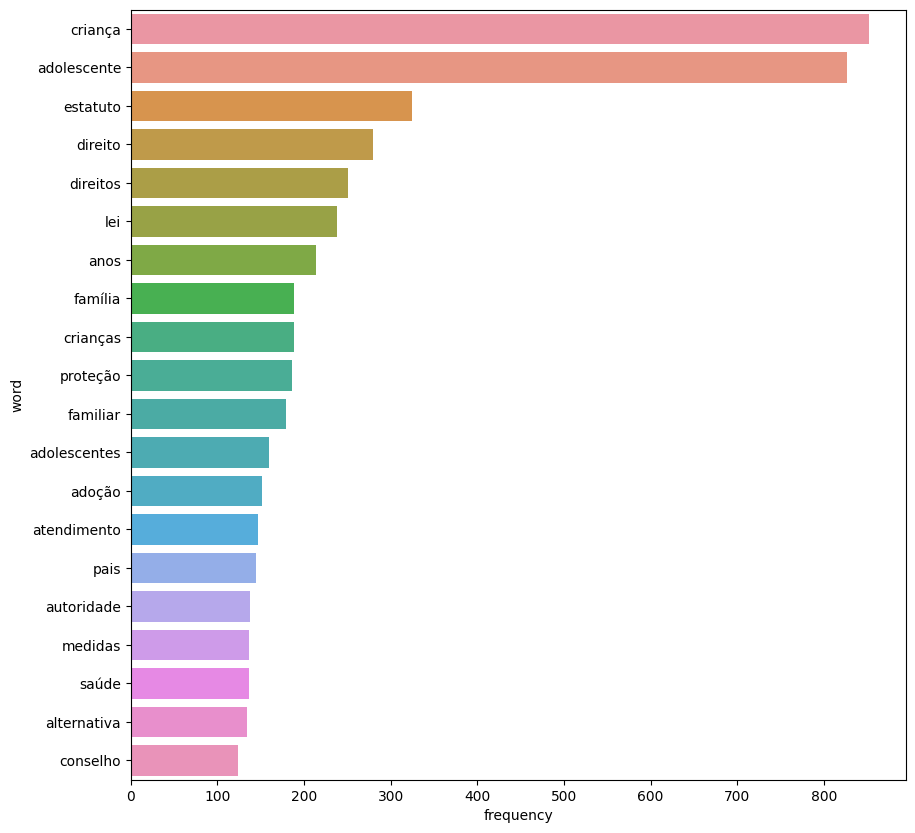

In [74]:
plt.subplots(figsize=(10,10))
sns.barplot(data=df_question_words.head(20), y='word', x='frequency')

## Release the BertTopic!

In [75]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\alexa\AppData\Local\Programs\Python\Python3

In [76]:
docs = df_social_workers['enunciado'] + ' - ' + df_social_workers['options']
len(docs)

484

In [77]:
representation_model = KeyBERTInspired()
topic_model = BERTopic(representation_model=representation_model)
topics, probs = topic_model.fit_transform(docs)

KeyboardInterrupt: 

In [45]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,439,0_adolescente_adolescentes_acolhimento_institucional,"[adolescente, adolescentes, acolhimento, institucional, educao, proteo, estatuto, esto, como, desenvolvimento]","[De acordo com os arts. 86 e 87 da Lei nº 8.069/90 (Estatuto da Criança e do Adolescente), far-se-á, através de um conjunto articulado de ações governamentais e não governamentais, da União, dos Estados, do Distrito Federal e dos Municípios, a política de atendimento dos direitos da criança e do adolescente. Em relação às linhas de ação da política de atendimento, segundo as disposições do Estatuto da Criança e do Adolescente, analise.\n\nI. Campanhas de estímulo ao acolhimento, sob forma de guarda de crianças e adolescentes afastados do convívio familiar, e à adoção, especificamente inter-racial, de crianças maiores ou de adolescentes, com necessidades específicas de saúde ou com deficiências, e de grupos de irmãos.\nII. Campanhas de orientação e acompanhamento vocacional de ordem pedagógica e educacional.\nIII. Políticas e programas de assistência social para aqueles que deles necessitem, em caráter supletivo.\nIV. Políticas e programas destinados a garantir o efetivo exercício d..."
1,1,45,1_adolescente_certo_estabelecido_adolescentes,"[adolescente, certo, estabelecido, adolescentes, socioeducativo, atividade, acolhimento, estatuto, proteo, institucional]","[Com base no Estatuto da Criança e do Adolescente (ECA), julgue o item a seguir. \nÉ assegurado ao adolescente o direito de recorrer a instância escolar superior para contestar critérios avaliativos.\n - ['Certo', 'Errado'], Com base no Estatuto da Criança e do Adolescente (ECA), julgue o item a seguir.\nÉ justificável a ausência escolar do adolescente que trabalhe em local e horário não compatíveis com a escola.\n - ['Certo', 'Errado'], De acordo com o disposto no Estatuto da Criança e do Adolescente (ECA), julgue o item subsequente.\n\nA adoção é medida excepcional e irrevogável, e não pode ser feita por procuração. O adotando deve ter, no máximo, dezoito anos de idade à data do pedido, salvo se já estiver sob a guarda ou tutela dos adotantes.\n\n\n - ['Certo', 'Errado']]"


### 2nd Model

In [47]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

In [48]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,439,0_de_da_do_ou,"[de, da, do, ou, adolescente, criana, que, em, no, ao]","[De acordo com os arts. 86 e 87 da Lei nº 8.069/90 (Estatuto da Criança e do Adolescente), far-se-á, através de um conjunto articulado de ações governamentais e não governamentais, da União, dos Estados, do Distrito Federal e dos Municípios, a política de atendimento dos direitos da criança e do adolescente. Em relação às linhas de ação da política de atendimento, segundo as disposições do Estatuto da Criança e do Adolescente, analise.\n\nI. Campanhas de estímulo ao acolhimento, sob forma de guarda de crianças e adolescentes afastados do convívio familiar, e à adoção, especificamente inter-racial, de crianças maiores ou de adolescentes, com necessidades específicas de saúde ou com deficiências, e de grupos de irmãos.\nII. Campanhas de orientação e acompanhamento vocacional de ordem pedagógica e educacional.\nIII. Políticas e programas de assistência social para aqueles que deles necessitem, em caráter supletivo.\nIV. Políticas e programas destinados a garantir o efetivo exercício d..."
1,1,45,1_errado_certo_de_julgue,"[errado, certo, de, julgue, item, do, no, da, adolescente, criana]","[Com base no Estatuto da Criança e do Adolescente (ECA), julgue o item a seguir. \nÉ assegurado ao adolescente o direito de recorrer a instância escolar superior para contestar critérios avaliativos.\n - ['Certo', 'Errado'], Com base no Estatuto da Criança e do Adolescente (ECA), julgue o item a seguir.\nÉ justificável a ausência escolar do adolescente que trabalhe em local e horário não compatíveis com a escola.\n - ['Certo', 'Errado'], De acordo com o disposto no Estatuto da Criança e do Adolescente (ECA), julgue o item subsequente.\n\nA adoção é medida excepcional e irrevogável, e não pode ser feita por procuração. O adotando deve ter, no máximo, dezoito anos de idade à data do pedido, salvo se já estiver sob a guarda ou tutela dos adotantes.\n\n\n - ['Certo', 'Errado']]"


# 3rd Model: multilanguage

In [78]:
representation_model = KeyBERTInspired()
topic_model = BERTopic(representation_model=representation_model, language='brazilian portuguese')
topics, probs = topic_model.fit_transform(docs)

In [80]:
pd.options.display.max_colwidth=100

In [81]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11,-1_afirmativas_afirmativa_criança_parental,"[afirmativas, afirmativa, criança, parental, correta, genitor, falsa, direitos, errado, pais]",[Leia as afirmativas a seguir:\nI. Nenhuma criança pode viajar para fora da comarca onde reside ...
1,0,265,0_crianças_infância_infracional_direitos,"[crianças, infância, infracional, direitos, autoridade, criança, dignidade, liberdade, adolescen...","[Sobre os direitos das crianças e adolescentes, com base na Lei 8.069, de julho de 1990, que dis..."
2,1,58,1_adoção_crianças_família_criança,"[adoção, crianças, família, criança, convivência, deverá, pais, comunitária, institucional, auto...",[Sobre o Direito à Convivência Familiar e Comunitária previsto no Estatuto da Criança e do Adole...
3,2,41,2_adoção_adotando_adotar_adotado,"[adoção, adotando, adotar, adotado, adotante, idade, criança, família, parentes, filho]","[Segundo a Lei 8.069, a adoção se reger-se à EXCETO: - ['O adotando deve contar com, no máximo, ..."
4,3,33,3_adolescentes_adolescente_menores_educativo,"[adolescentes, adolescente, menores, educativo, idade, educação, escolar, profissionalização, en...","[De acordo com a Lei n. 8.069/90 – Estatuto da Criança e do Adolescente, somente aos adolescente..."
5,4,28,4_neonato_gestação_nascimento_criança,"[neonato, gestação, nascimento, criança, público, públicos, mães, nascido, filhos, saúde]","[Sobre a lei nº 8.069 de 13 de julho de 1990, que dispõe sobre a proteção integral de crianças e..."
6,5,25,5_idade_juventude_adolescente_adolescentes,"[idade, juventude, adolescente, adolescentes, criança, 18, anos, 16, judicial, 15]","[Em relação à política de proteção à criança e ao adolescente, conforme a Lei 8.069/1990, consid..."
7,6,23,6_jurisdicional_constitua_municipal_administrativa,"[jurisdicional, constitua, municipal, administrativa, município, administração, mandato, encarre...","[Conforme disposto no Art. 131 do Estatuto da Criança e do Adolescente (ECA), o Conselho Tutelar..."


In [85]:
print(topic_model.get_topic_info()[['Topic', 'Count', 'Name', 'Representation']].to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Topic</th>
      <th>Count</th>
      <th>Name</th>
      <th>Representation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>-1</td>
      <td>11</td>
      <td>-1_afirmativas_afirmativa_criança_parental</td>
      <td>[afirmativas, afirmativa, criança, parental, correta, genitor, falsa, direitos, errado, pais]</td>
    </tr>
    <tr>
      <td>0</td>
      <td>265</td>
      <td>0_crianças_infância_infracional_direitos</td>
      <td>[crianças, infância, infracional, direitos, autoridade, criança, dignidade, liberdade, adolescentes, adolescente]</td>
    </tr>
    <tr>
      <td>1</td>
      <td>58</td>
      <td>1_adoção_crianças_família_criança</td>
      <td>[adoção, crianças, família, criança, convivência, deverá, pais, comunitária, institucional, autoridade]</td>
    </tr>
    <tr>
      <td>2</td>
      <td>41</td>
      <td>2_adoção_adotando_adotar_adotado</td>
      <td>[adoção,

In [103]:
pd.options.display.max_colwidth = 500
pd.DataFrame(topic_model.get_representative_docs(docs)).T.reset_index().melt(id_vars=['index']).sort_values(by=['index', 'variable'])

,index,variable,value
0,-1,0,"Leia as afirmativas a seguir:\nI. Nenhuma criança pode viajar para fora da comarca onde reside sem estar acompanhada por ambos os pais, de acordo com o Estatuto da Criança e do Adolescente. II. Toda criança tem o direito de ser respeitada por seus educadores, de acordo com o Estatuto da Criança e do Adolescente.\nMarque a alternativa CORRETA: - ['As duas afirmativas são verdadeiras.', 'A afirmativa I é verdadeira, e a II é falsa.', 'A afirmativa II é verdadeira, e a I é falsa.', 'As duas afi..."
8,-1,1,"Leia as afirmativas a seguir: I. Dificultar o contato de criança ou adolescente com o genitor é um ato de alienação parental. II. A criança e o adolescente gozam de todos os direitos fundamentais inerentes à pessoa humana. Marque a alternativa CORRETA: - ['As duas afirmativas são verdadeiras.', 'A afirmativa I é verdadeira, e a II é falsa.', 'A afirmativa II é verdadeira, e a I é falsa.', 'As duas afirmativas são falsas.']"
16,-1,2,"Leia as afirmativas a seguir:\nI. A criança não tem o direito de contestar os critérios avaliativos utilizados na instituição de ensino, de acordo com o Estatuto da Criança e do Adolescente. II. O Estatuto da Criança e do Adolescente retira da criança e do adolescente o direito à Educação Básica.\nMarque a alternativa CORRETA: - ['As duas afirmativas são verdadeiras.', 'A afirmativa I é verdadeira, e a II é falsa.', 'A afirmativa II é verdadeira, e a I é falsa.', 'As duas afirmativas são fal..."
1,0,0,"Sobre os direitos das crianças e adolescentes, com base na Lei 8.069, de julho de 1990, que dispõe sobre o Estatuto da Criança e do Adolescente - ECA, assinale a alternativa INCORRETA: - ['Os casos de suspeita ou confirmação de castigo físico, de tratamento cruel ou degradante e de maus-tratos contra criança ou adolescente serão obrigatoriamente comunicados no prazo de 24 (vinte e quatro) horas ao conselho tutelar da respectiva localidade, sem necessidade de outras providências legais.', 'Os..."
9,0,1,"Considerando a Lei nº 8.069/1990, que dispõe sobre o Estatuto da Criança e do Adolescente (ECA), analise as assertivas abaixo e assinale V, se verdadeiras, ou F, se falsas.\n\n\n\n\n( ) Os serviços de saúde, em suas diferentes portas de entrada, os serviços de assistência social, em seu componente especializado, o Centro de Referência Especializado de Assistência Social (CREAS) e os demais órgãos do Sistema de Garantia de Direitos da Criança e do Adolescente deverão conferir máxima prioridad..."
17,0,2,"Conforme preceitua do ECA - Estatuto da Criança e do Adolescente (Lei n.° 8.069, de 13 de julho de 1990), a União, os Estados, o Distrito Federal e os Municípios deverão atuar de forma articulada na elaboração de políticas públicas e na execução de ações destinadas a coibir o uso de castigo físico ou de tratamento cruel ou degradante e difundir formas não violentas de educação de crianças e de adolescentes, tendo como principais ações, exceto:\n - ['a integração com os órgãos do Poder Judici..."
2,1,0,"Sobre o Direito à Convivência Familiar e Comunitária previsto no Estatuto da Criança e do Adolescente é INCORRETO afirmar: - ['Toda criança ou adolescente que estiver inserido em programa de acolhimento familiar ou institucional terá sua situação reavaliada, no máximo, a cada 3 (três) meses, devendo a autoridade judiciária competente, com base em relatório elaborado por equipe interprofissional ou multidisciplinar, decidir de forma fundamentada pela possibilidade de reintegração familiar ou ..."
10,1,1,"De acordo com o Estatuto da Criança e do Adolescente, Art. 19. É direito da criança e do adolescente ser criado e educado no seio de sua família e, excepcionalmente, em família substituta, assegurada a convivência familiar e comunitária, em ambiente que garanta seu desenvolvimento integral. Assinale a alternativa referente ao artigo citado acima: - ['A permanência da criança e do adolescente em programa de acolhimento institucional não se prolongará por mais de 24 (vinte e quat

In [96]:
topic_model.get_topic(6)

[('jurisdicional', 0.5091328),
 ('constitua', 0.49673033),
 ('municipal', 0.46407107),
 ('administrativa', 0.4547501),
 ('município', 0.4374397),
 ('administração', 0.42733815),
 ('mandato', 0.42058182),
 ('encarregado', 0.40611142),
 ('direitos', 0.40490785),
 ('sociedade', 0.4043648)]

In [107]:
pd.options.display.max_colwidth = 100

In [114]:
topic_model.get_document_info(docs).columns

Index(['Document', 'Topic', 'Name', 'Representation', 'Representative_Docs',
       'Top_n_words', 'Probability', 'Representative_document'],
      dtype='object')

In [118]:
df_social_workers_topics = pd.merge(left=df_social_workers.reset_index(), right=topic_model.get_document_info(docs), left_index=True, right_index=True)

In [169]:
df_social_workers_topics[df_social_workers_topics.Topic == 0].explode('n_articles')['n_articles'].value_counts()[:10].reset_index()

,index,n_articles
0,4,6
1,56,5
2,112,5
3,16,4
4,11,3
5,87,3
6,130,3
7,3,3
8,7,3
9,18,3


-------------------------
Tópico nº 0
-------------------------
-------------------------
Tópico nº 1
-------------------------
-------------------------
Tópico nº 2
-------------------------
-------------------------
Tópico nº 3
-------------------------
-------------------------
Tópico nº 4
-------------------------
-------------------------
Tópico nº 5
-------------------------
-------------------------
Tópico nº 6
-------------------------


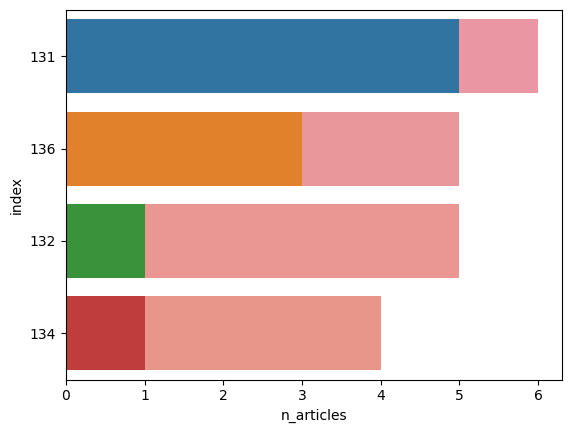

In [170]:
for topic in range(7):
    print('-' * 25)
    print(f'Tópico nº {topic}')
    
    print('-' * 25)

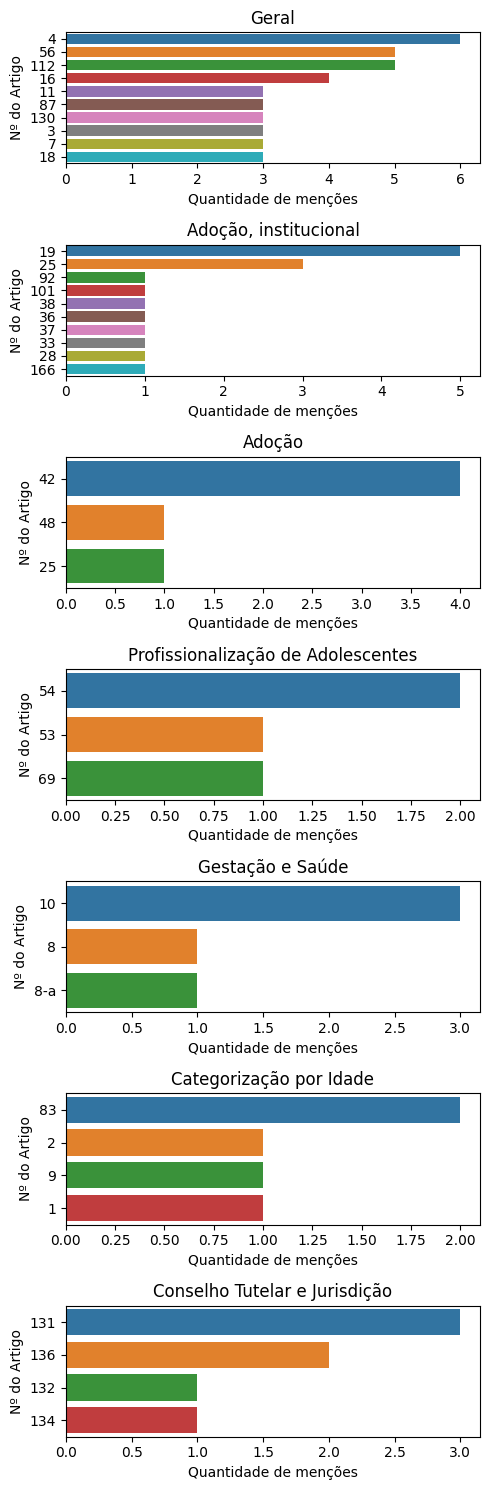

In [182]:
fig, ax = plt.subplots(7, 1, figsize=(5, 15))
topics_list = ['Geral', 'Adoção, institucional', 'Adoção', 'Profissionalização de Adolescentes', 'Gestação e Saúde', 'Categorização por Idade', 'Conselho Tutelar e Jurisdição']
for i in range(7):
    plot = sns.barplot(data=df_social_workers_topics[df_social_workers_topics.Topic == i].explode('n_articles')['n_articles'].value_counts().reset_index()[:10], x='n_articles', y='index', ax=ax[i])
    plot.set_title(topics_list[i])
    plot.set_xlabel('Quantidade de menções')
    plot.set_ylabel('Nº do Artigo')
plt.tight_layout()

# PDF

In [16]:
!py -m pip install fpdf


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40712 sha256=7f5389989f10a65f60dbf17e15deb6f3a3f866caa97fe4c94425cf56c318eea0
  Stored in directory: c:\users\alexa\appdata\local\pip\cache\wheels\42\d3\88\951369f6b04bdae4583b977c5c94459a07ee3b1e44abe9d766
Successfully built fpdf


In [21]:
import os
import shutil
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from fpdf import FPDF
from datetime import datetime
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

In [20]:
class PDF(FPDF):
    def __init__(self):
        super().__init__()
        self.WIDTH = 210
        self.HEIGHT = 297

    def header(self):
        # self.image('assets/logo.png', 10, 8, 33)
        self.set_font('Arial', 'B', 11)
        self.cell(self.WIDTH - 80)
        self.cell(60, 1, 'Relatório', 0, 0, 'R')
        self.ln(20)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.set_text_color(128)
        self.cell(0, 10, 'Page ' + str(self.page_no()), 0, 0, 'C')

    def page_body(self, images):
        self.image(images[0], 15, 25, self.WIDTH - 30)
        if len(images) > 1:
            self.image(images[1], 15, self.WIDTH / 2 + 5, self.WIDTH - 30)
        if len(images) > 2:
            self.image(images[2], 15, self.WIDTH / 2 + 90, self.WIDTH - 30)

    def print_page(self, images):
        self.add_page()
        self.page_body(images) 

In [22]:
df_social_workers.columns

Index(['enunciado', 'options', 'ano', 'banca', 'orgao', 'prova',
       'cited_articles', 'cited_articles_options', 'articles_mentioned',
       'n_articles', 'paragraphs_mentioned', 'chapters_mentioned',
       'titles_mentioned', 'incisos_mentioned'],
      dtype='object')

In [ ]:
def plot(data: pd.DataFrame, filename: str) -> None:
    plt.figure(figsize=(12, 4))
    plt.grid(color='#F2F2F2', alpha=1, zorder=0)
    plt.plot(data[''])

In [ ]:
PLOT_DIR = 'plots'

def construct():
    try:
        shutil.rmtree(PLOT_DIR)
        os.mkdir(PLOT_DIR)
    except FileNotFoundError:
        os.mkdir(PLOT_DIR)
    
    for i in range(2, 13):
        plot(data=)

In [ ]:
plots_per_page = construct()
plots_per_page

In [ ]:
pdf = PDF()
for elem in plots_per_page:
    pdf.print_page(elem)
pdf.output('Report.pdf', 'F')

## Second Data Analysis

In [35]:
df_questions.shape

(4972, 14)

In [23]:
df_social_workers.shape

(484, 14)

Text(0, 0.5, 'Nº de Questões')

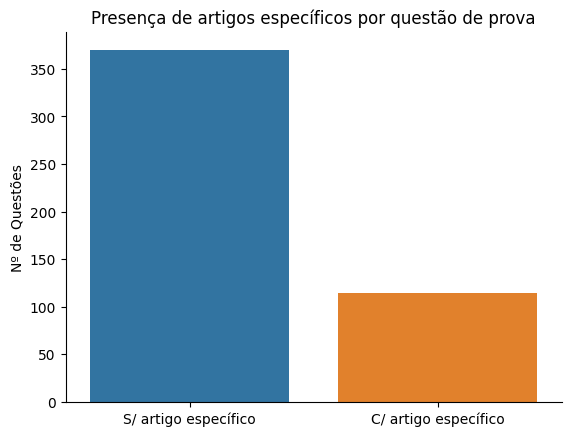

In [33]:
missing_count = df_social_workers.n_articles.isna().sum()
filled_count = df_social_workers.n_articles.notna().sum()
sns.barplot(x=['S/ artigo específico', 'C/ artigo específico'], y=[missing_count, filled_count])
plt.title('Presença de artigos específicos por questão de prova')
plt.ylabel('Nº de Questões')

In [34]:
df_mentioned_articles = df_social_workers[df_social_workers['n_articles'].notna()]
df_mentioned_articles.shape

(114, 14)

In [44]:
count_articles

,count,n_articles
0,4,6
1,112,5
2,56,5
3,19,5
4,16,4
...,...,...
84,176,1
85,186,1
86,171,1
87,174,1


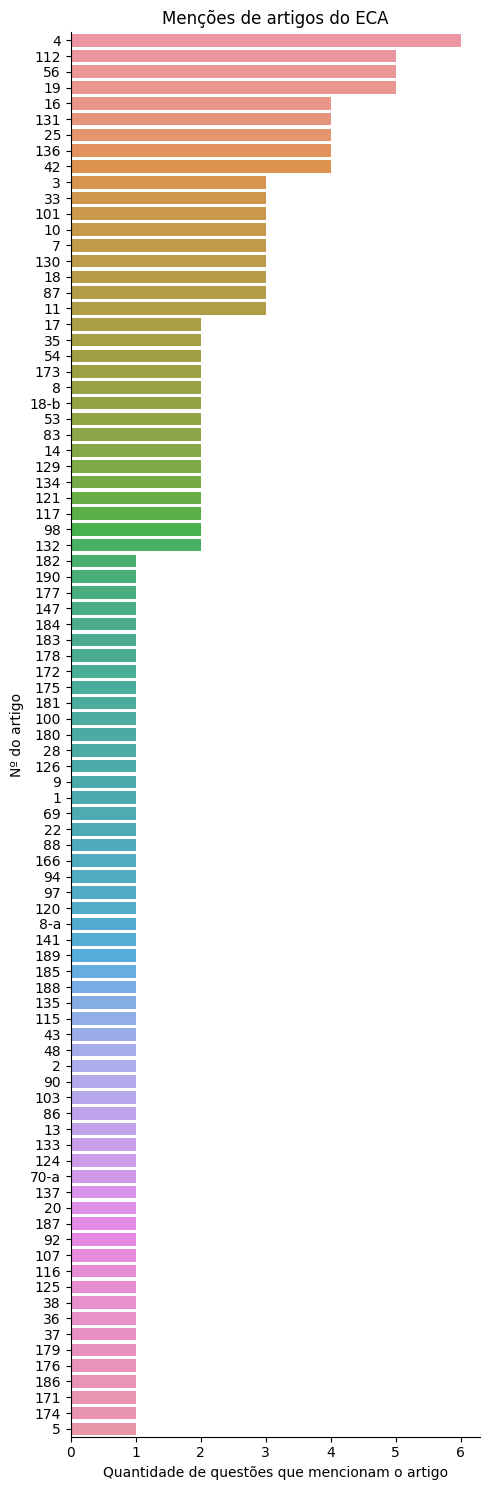

In [91]:
# Counting the articles mentioned in the original dataset and ordering by most asked articles
plt.subplots(figsize=(5, 15))
plt.title('Menções de artigos do ECA')
sns.barplot(data=count_articles, x='n_articles', y='count')
plt.ylabel('Nº do artigo')
plt.xlabel('Quantidade de questões que mencionam o artigo')
plt.tight_layout()

In [98]:
count_articles.sort_values(by='count', )

,count,n_articles
48,1,1
12,10,3
43,100,1
11,101,3
67,103,1
...,...,...
66,90,1
76,92,1
53,94,1
54,97,1


In [95]:
print(count_articles.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
      <th>n_articles</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>4</td>
      <td>6</td>
    </tr>
    <tr>
      <th>1</th>
      <td>112</td>
      <td>5</td>
    </tr>
    <tr>
      <th>2</th>
      <td>56</td>
      <td>5</td>
    </tr>
    <tr>
      <th>3</th>
      <td>19</td>
      <td>5</td>
    </tr>
    <tr>
      <th>4</th>
      <td>16</td>
      <td>4</td>
    </tr>
    <tr>
      <th>5</th>
      <td>131</td>
      <td>4</td>
    </tr>
    <tr>
      <th>6</th>
      <td>25</td>
      <td>4</td>
    </tr>
    <tr>
      <th>7</th>
      <td>136</td>
      <td>4</td>
    </tr>
    <tr>
      <th>8</th>
      <td>42</td>
      <td>4</td>
    </tr>
    <tr>
      <th>9</th>
      <td>3</td>
      <td>3</td>
    </tr>
    <tr>
      <th>10</th>
      <td>33</td>
      <td>3</td>
    </tr>
    <tr>
      <th>11</th>
      <td>101

In [103]:
df_social_workers[df_social_workers['n_articles'].notna()][['n_articles', 'paragraphs_mentioned', 'chapters_mentioned', 'titles_mentioned', 'incisos_mentioned']]

,n_articles,paragraphs_mentioned,chapters_mentioned,titles_mentioned,incisos_mentioned
14,{11},NaN,NaN,NaN,NaN
90,{3},NaN,NaN,NaN,NaN
128,{141},NaN,NaN,NaN,NaN
129,{132},NaN,NaN,NaN,NaN
130,"{129, 130}",NaN,NaN,NaN,[ vii) ]
...,...,...,...,...,...
4771,{5},NaN,NaN,NaN,NaN
4777,{101},NaN,NaN,NaN,NaN
4793,{87},NaN,NaN,NaN,NaN
4913,{10},NaN,NaN,NaN,NaN


In [83]:
df_mentioned_details = pd.DataFrame()
for article in df_final['n_articles_y'].unique():
    df_mentioned_details = pd.concat([df_mentioned_details, df_final[df_final['n_articles_y'] == article][['n_articles_y', 'paragraphs_mentioned', 'chapters_mentioned', 'titles_mentioned', 'incisos_mentioned']]], axis=0)

In [85]:
df_mentioned_details[df_mentioned_details['paragraphs_mentioned'].notna()]

,n_articles_y,paragraphs_mentioned,chapters_mentioned,titles_mentioned,incisos_mentioned
27,11,[§ 2],NaN,NaN,NaN
115,130,[parágrafo único],[capítulo v],[título iv],NaN
7,121,"[parágrafo terceiro, parágrafo quinto]",NaN,NaN,NaN
8,125,"[parágrafo terceiro, parágrafo quinto]",NaN,NaN,NaN
49,14,[§ 1],NaN,NaN,NaN
30,101,[parágrafo 7],NaN,NaN,[ viii) ]
88,42,[§ 2],NaN,NaN,NaN
94,42,"[§ 1, § 2, § 3, § 4, § 6]",NaN,NaN,NaN
39,25,[parágrafo único],NaN,NaN,NaN
143,25,"[parágrafo único, § 1]",[capítulo iii],NaN,"[ i, ]"
